In [1]:
import os

In [2]:
import pickle
import numpy as np
import random
import multiprocessing

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [4]:
from scipy.stats import gaussian_kde

In [5]:
from scipy.misc import imsave

In [6]:
import math
def get_data(X, BATCH_SIZE):
    index = 0
    while True:
        if index + BATCH_SIZE <= len(X):
            data = X[index:index+BATCH_SIZE]
            index += BATCH_SIZE
        else:
            data = X[:BATCH_SIZE]
            index = BATCH_SIZE
        yield data


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img[:, :, :]
    return image

In [7]:
import tensorflow as tf
session = tf.Session()

In [8]:
imported_meta = tf.train.import_meta_graph("./model/model.ckpt-100000.meta")  

In [9]:
imported_meta.restore(session, tf.train.latest_checkpoint('./model/'))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-100000


In [10]:
image_input = session.graph.get_tensor_by_name("Placeholder_2:0")
critic_output = session.graph.get_tensor_by_name("Reshape_1:0")

In [11]:
def softplus(x):
    return np.log(1.0 + np.exp(x))

In [64]:
BASE_DIR = os.getcwd()
STATS_DIR = os.path.join(BASE_DIR, "stats")
MODE = "train"
fname = os.path.join(STATS_DIR, MODE+"_outputs.pkl")
with open(fname, "rb") as f:
    d = pickle.load(f)
X = d["images"]
y = np.array(d["labels"]) if d["labels"] is not None else None
d_out = np.array(d["critic_outputs"])

In [65]:
d_out.shape

(9984,)

In [66]:
X.shape, X.dtype

((9984, 32, 32, 3), dtype('uint8'))

In [67]:
class Local:
    def __init__(self, patch_size):
        self.patch_size = patch_size
        self.pool = multiprocessing.Pool()
    
    def rejig_image(self, image):
        rejig = image.copy()
        random_height, random_width = np.random.randint(0, 32-self.patch_size+1, 2)
        np.random.shuffle(rejig[random_height:random_height+self.patch_size,\
                                random_width:random_width+self.patch_size, :])
        return rejig
    
    def map(self, image):
        return (self.pool).map(self.rejig_image, images)
    
    def __getstate__(self):
        self_dict = self.__dict__.copy()
        del self_dict['pool']
        return self_dict

    def __setstate__(self, state):
        self.__dict__.update(state)

In [68]:
batches = len(X) // 64

In [69]:
batches

156

In [55]:
for f in [2, 3, 4, 5, 8, 16, 32]:
    shuffler = Local(f)
    d_fake = []
    for i in range(batches):
        images = X[i*64:(i+1)*64]
        rejiged = np.array(shuffler.map(images))
        fd = {image_input:(rejiged - 127.5)/127.5}
        _d_fake = session.run(critic_output, feed_dict=fd)
        d_fake.append(_d_fake)
    d_fake = np.array(d_fake).flatten()
    loss = softplus(d_fake) + softplus(-d_out)
    print("Error, Loss {}: {} {}".format(f, np.mean(np.absolute(d_out - d_fake)), np.mean(loss)))

Error, Loss 2: 1.2032368183135986 1.7107226848602295
Error, Loss 3: 1.200979232788086 1.704603910446167
Error, Loss 4: 1.1965570449829102 1.6959502696990967
Error, Loss 5: 1.1987884044647217 1.690832495689392
Error, Loss 8: 1.2192925214767456 1.7302829027175903
Error, Loss 16: 2.3913350105285645 3.119769334793091
Error, Loss 32: 7.208259582519531 8.087034225463867


In [56]:
np.min(rejiged), np.max(rejiged)

(0, 255)

In [57]:
class Global:
    def __init__(self, patch_size):
        self.patch_size = patch_size
        assert(32 % patch_size == 0)
        self.pool = multiprocessing.Pool()
    
    def swapper(self, image):
        copy = image.copy()
        x1, y1, x2, y2 = np.random.randint(0, 32//self.patch_size, 4)
        while x1 == x2 and y1 == y2:
            x1, y1, x2, y2 = np.random.randint(0, 32//self.patch_size, 4)
        x1, y1, x2, y2 = x1*self.patch_size, y1*self.patch_size, x2*self.patch_size, y2*self.patch_size
        tmp = copy[x1:x1+self.patch_size, y1:y1+self.patch_size].copy()
        copy[x1:x1+self.patch_size, y1:y1+self.patch_size] = \
                    copy[x2:x2+self.patch_size, y2:y2+self.patch_size].copy()
        copy[x2:x2+self.patch_size, y2:y2+self.patch_size] = tmp
        return copy
    
    def map(self, image):
        return (self.pool).map(self.swapper, images)
    
    def __getstate__(self):
        self_dict = self.__dict__.copy()
        del self_dict['pool']
        return self_dict

    def __setstate__(self, state):
        self.__dict__.update(state)

In [70]:
for f in [2, 4, 8, 16]:
    patcher = Global(f)
    d_fake = []
    for i in range(batches):
        images = X[i*64:(i+1)*64]
        rejiged = np.array(patcher.map(images))
        fd ={image_input:(rejiged - 127.5)/127.5}
        _d_fake = session.run(critic_output, feed_dict = fd)
        d_fake.append(_d_fake)
    d_fake = np.array(d_fake).flatten()
    loss = softplus(d_fake) + softplus(-d_out)
    print("Error, Loss {}: {} {}".format(f, np.mean(np.absolute(d_out - d_fake)), np.mean(loss)))

Error, Loss 2: 1.2340530157089233 1.7161239385604858
Error, Loss 4: 1.2391833066940308 1.7210456132888794
Error, Loss 8: 1.2975701093673706 1.716249704360962
Error, Loss 16: 1.418927550315857 1.6660687923431396


In [71]:
_d_out = d_out[len(d_out)-64:len(d_out)]
error = np.absolute(_d_out - _d_fake)
sorted_indices = np.argsort(error)
error[sorted_indices]

array([0.03879333, 0.05995888, 0.06484103, 0.07281914, 0.13981903,
       0.14342636, 0.18610713, 0.19723025, 0.21331358, 0.2644323 ,
       0.3000083 , 0.3326826 , 0.34143195, 0.4390125 , 0.4401368 ,
       0.50450957, 0.6545725 , 0.8057915 , 0.8741807 , 0.88693404,
       0.9139124 , 0.9247639 , 1.0000924 , 1.04752   , 1.0852509 ,
       1.1337342 , 1.1492189 , 1.2290814 , 1.2333343 , 1.3043835 ,
       1.3236032 , 1.3643873 , 1.3879113 , 1.3951057 , 1.3982677 ,
       1.4084991 , 1.4170336 , 1.4197707 , 1.5322312 , 1.5715882 ,
       1.5995822 , 1.6209515 , 1.633575  , 1.6579511 , 1.7225267 ,
       1.8474123 , 1.9810891 , 2.1617537 , 2.2137003 , 2.299619  ,
       2.3041358 , 2.3489366 , 2.443865  , 2.4548283 , 2.6117144 ,
       2.9039478 , 3.0422845 , 3.138493  , 3.2085128 , 3.4099865 ,
       3.6971858 , 4.7325926 , 5.2027206 , 6.0870376 ], dtype=float32)

In [72]:
_d_out

array([ 1.2832011 ,  1.5379381 ,  1.262852  , -0.4274723 ,  1.0513868 ,
        1.5503484 ,  0.44496322,  1.322332  ,  0.1715557 , -0.52185076,
       -0.6220805 , -0.17611775,  2.1958592 ,  4.1922116 ,  2.6775212 ,
       -0.01667478, -0.01344376,  0.08145323, -1.2566229 ,  1.6184425 ,
       -0.40474933, -0.01218113,  1.0159223 ,  1.1607708 , -0.50866145,
       -0.09435193,  0.9623717 , -0.5855953 ,  0.42075455, -0.6998219 ,
        0.7364621 ,  1.4954929 , -0.18296161,  1.4128567 ,  3.1928797 ,
        1.4555643 ,  0.41213074,  0.3023905 ,  1.9490391 ,  2.3590357 ,
        0.19621399,  1.690473  , -0.85273945,  3.6934452 , -0.7673166 ,
       -0.20027745,  0.25189632,  1.4457319 ,  0.48670337, -0.8763174 ,
        1.345898  , -0.06260214, -0.7490703 ,  0.20903513,  2.326359  ,
        0.18154243,  0.47654575,  2.481036  ,  0.34973064,  1.2295456 ,
        1.5727416 , -0.04011562,  2.4714851 ,  0.22538012], dtype=float32)

In [73]:
_d_fake

array([ 0.04986686,  0.00570686,  1.402671  ,  1.7342814 ,  1.1162279 ,
        1.763662  ,  2.6586635 ,  2.7393656 , -0.33295384, -0.33574364,
       -0.6820394 ,  0.26401904, -1.0126537 , -1.010509  , -0.22642651,
       -1.6376263 ,  0.05937538,  1.5012239 ,  1.047513  , -0.1040841 ,
       -0.20751908,  1.2922024 , -0.3076808 ,  0.89633846,  0.4914309 ,
       -1.2435708 ,  3.574086  , -0.24416336, -0.80832684,  5.3872156 ,
        1.6233962 , -0.80412596, -0.6219741 ,  0.2791224 , -0.50430614,
        2.8434756 , -0.9522565 , -1.3311845 ,  0.5507713 , -0.7794573 ,
       -1.4033682 , -0.65846354,  1.1283497 , -1.0391476 ,  1.6875116 ,
        1.1948283 ,  0.39532268, -0.12585625, -0.42720902,  0.9710949 ,
        0.42113414, -0.39528474,  2.6609163 , -0.6651456 ,  1.5205675 ,
       -0.9037084 ,  0.17653745, -0.5612485 , -0.30484185,  0.18202558,
       -0.08520953,  1.3683835 ,  0.02761998,  0.1865868 ], dtype=float32)

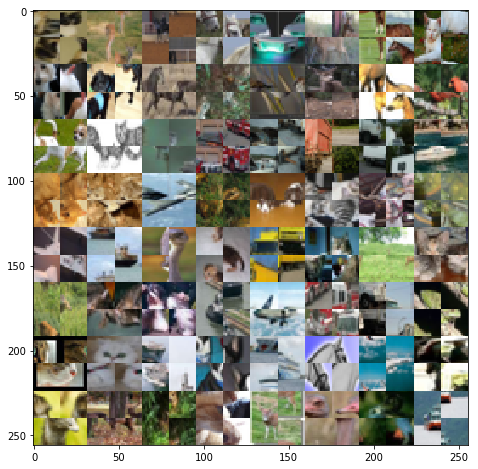

In [74]:
fg = figure(figsize=(8, 8))
plt.imshow(combine_images(rejiged[sorted_indices]))
plt.show()

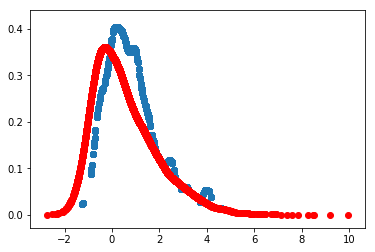

In [75]:
kde = gaussian_kde(d_out)
kde_ = gaussian_kde(d_fake)
est_ = kde_(d_fake).tolist()
est = kde(d_out).tolist()
plt.scatter(d_out, est)
plt.scatter(d_fake, est_, c='r')
plt.show()